# Import Libraries and Tools


In [1]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

import tensorflow as tf

# importing keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [ ]:
print(tf.__version__)

2.19.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset



In [ ]:
# directories from training adn testing data sets
train_dir= '/content/drive/MyDrive/MRI Images/Training'
test_dir= '/content/drive/MyDrive/MRI Images/Testing'

# load and shuffle the train data
train_paths=[]
train_labels=[]

for label in os.listdir(train_dir):
  print(label)
  for img_path in os.listdir(os.path.join(train_dir, label)):
    # print(Image)
    train_paths.append(os.path.join(train_dir, label, img_path))
    train_labels.append(label)

train_paths, train_labels= shuffle(train_paths, train_labels)
train_paths


# load for shuffle the test data
test_paths=[]
test_labels=[]

for label in os.listdir(test_dir):
  print(label)
  for img_path in os.listdir(os.path.join(test_dir, label)):
    # print(Image)
    test_paths.append(os.path.join(test_dir, label, img_path))
    test_labels.append(label)

test_paths, test_labels= shuffle(test_paths, test_labels)
test_paths


pituitary
notumor
meningioma
glioma
meningioma
pituitary
notumor
glioma


['/content/drive/MyDrive/MRI Images/Testing/notumor/Te-no_0296.jpg',
 '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-me_0014.jpg',
 '/content/drive/MyDrive/MRI Images/Testing/notumor/Te-noTr_0006.jpg',
 '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-pi_0242.jpg',
 '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-pi_0111.jpg',
 '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-pi_0126.jpg',
 '/content/drive/MyDrive/MRI Images/Testing/notumor/Te-no_0179.jpg',
 '/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0033.jpg',
 '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-me_0242.jpg',
 '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-pi_0298.jpg',
 '/content/drive/MyDrive/MRI Images/Testing/notumor/Te-no_0164.jpg',
 '/content/drive/MyDrive/MRI Images/Testing/pituitary/Te-pi_0014.jpg',
 '/content/drive/MyDrive/MRI Images/Testing/glioma/Te-gl_0117.jpg',
 '/content/drive/MyDrive/MRI Images/Testing/meningioma/Te-me_0080.jpg',
 '/content/driv

# Data vizualization

0 3999
1 15
2 1822
3 3579
4 2780
5 2277
6 3145
7 4094
8 2695
9 773


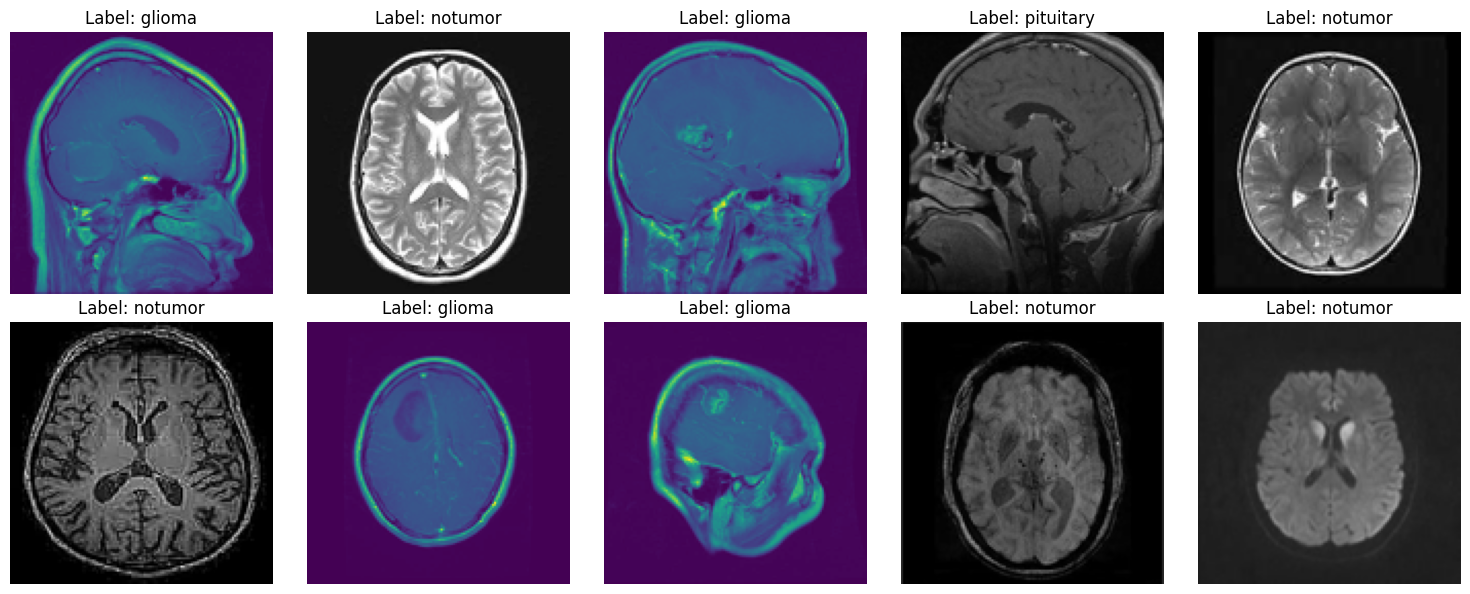

In [ ]:
import random
import matplotlib.pyplot as plt

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)
random_indices

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

axes = axes.ravel()

#loop theough the random indeces and display images
for i, idx in enumerate(random_indices):
  print(i,idx)
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((128, 128))

  # Display images
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f"Label: {train_labels[idx]}")

plt.tight_layout()
plt.show()

# Image Preprocessing (Helper Functions)

In [ ]:
from enum import unique
from re import I
# Image Augmentaion Funtion
def augment_image(image):

    image = Image.fromarray(np.uint8(image))
    image= ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image= ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

# load images and apply augmentation
def open_images(paths):
    images=[]
    for path in paths:
        image= load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image=augment_image(image)
        images.append(image)
    return np.array(images)


# Encoder labels (Converts label names to integers)
def encode_label(labels):
    unique_labels= os.listdir(train_dir)
    encoded= [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
          batch_paths= paths[i:i+batch_size]
          batch_images = open_images(batch_paths)     # open and augment images
          batch_labels= labels[i:i+batch_size]
          batch_labels = encode_label(batch_labels)   # encode label
          yield batch_images, batch_labels

# Model:

We are using VGG16 for transfer learning.

The model is built on top of VGG16, which is a pre-trained convolutional neural network(CNN) for image classification

In [ ]:
# Modal Arcitecture (128, 128,3)
IMAGE_SIZE= 128
base_model= VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
  layer.trainable=False

# Set only the last few layers
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True

# Build modal
model=Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # imput layer
model.add(base_model)    # VGG16 model
model.add(Flatten())   # Flatten layer
model.add(Dropout(0.3))  # Dropout layre drop randomly 30 neuron to secure from overfitting in model
model.add(Dense(128, activation='relu'))  # Dense layer
model.add(Dropout(0.2))  # Dropout layre drop randomly 20 neuron to secure from overfitting in model
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer


# compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# parameters
batch_size=20
steps=int(len(train_paths)/batch_size)
epochs=5


# train model
history = model.fit(
    datagen(train_paths,train_labels, batch_size=batch_size),
    epochs=epochs,
    steps_per_epoch=steps
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1226s 4s/step - loss: 0.6455 - sparse_categorical_accuracy: 0.7420
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 40us/step - loss: 0.0257 - sparse_categorical_accuracy: 1.0000 
Epoch 3/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.2031 - sparse_categorical_accuracy: 0.9247 
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.2253 - sparse_categorical_accuracy: 0.9251 
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.2035 - sparse_categorical_accuracy: 0.8998 


# Train and Val Plots

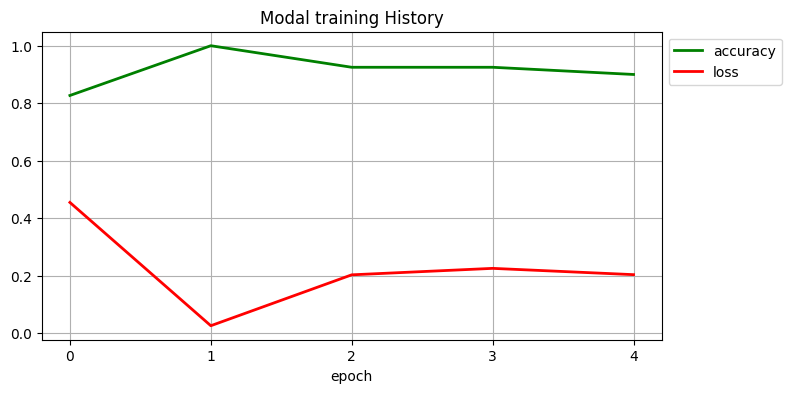

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'],'g-',linewidth=2)
plt.plot(history.history['loss'],'r-',linewidth=2)
plt.title('Modal training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['accuracy','loss'], loc='upper left',bbox_to_anchor=(1,1))
plt.show()

# Modal Classification Report

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import label_binarize
# import numpy as np

# test_images= open_images(test_paths)
# test_labels_encoded= encode_label(test_labels)

# test_predictions= model.predict(test_images)
# print("Classification REport:")
# print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 222s 5s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89       300
           1       0.97      0.95      0.96       405
           2       0.78      0.68      0.73       306
           3       0.86      0.81      0.83       300

    accuracy                           0.86      1311
   macro avg       0.85      0.86      0.85      1311
weighted avg       0.86      0.86      0.86      1311



# Modal confusion plot


Confusion Matrix:
[[294   1   3   2]
 [  7 383  13   2]
 [ 50  10 209  37]
 [ 12   2  42 244]]


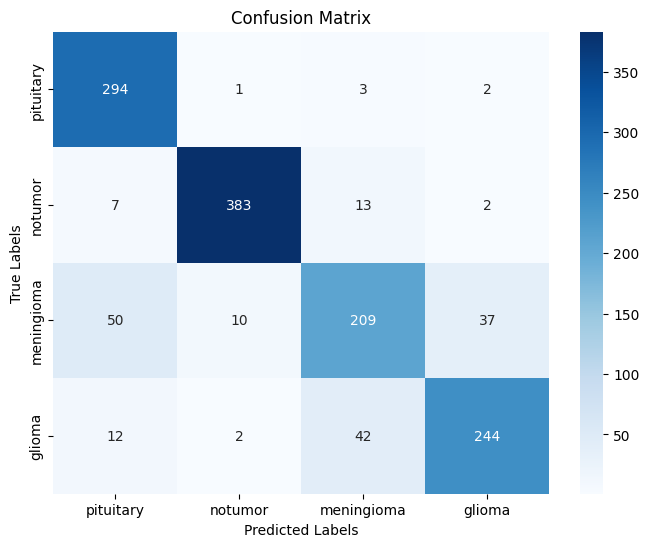

In [ ]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ROC Curve Plot

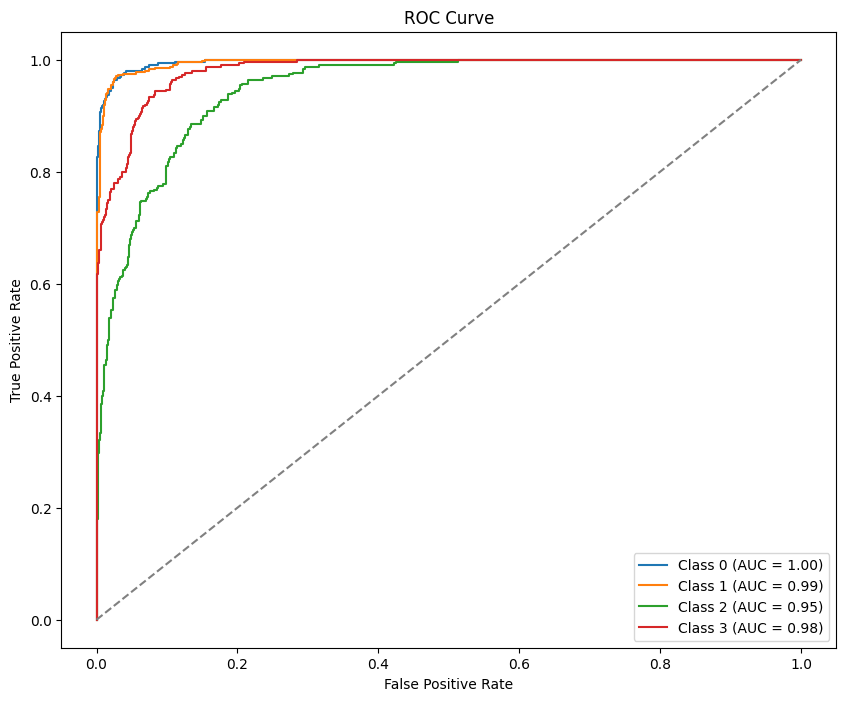

In [ ]:
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Save and load Modal

In [ ]:
model.save('model.brain_tumor_classifier.keras')
MODEL_PATH = "/content/drive/MyDrive/brain_tumor_classifier.keras"

In [ ]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.brain_tumor_classifier.keras')

# MRI Tumour Detection System


In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


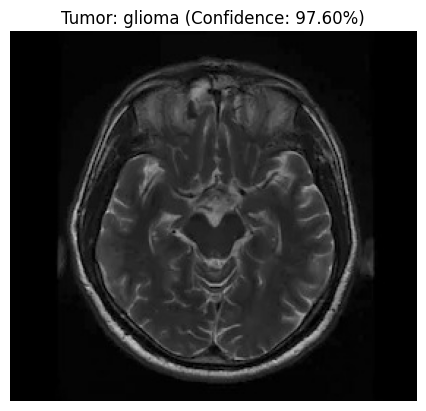

In [ ]:
image_path = '/content/drive/MyDrive/MRI Images/Testing/notumor/Te-noTr_0006.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

In [ ]:

import os
os.path.exists("/content/drive/MyDrive/brain_tumor_classifier.keras")


False

In [ ]:
!ls /content/drive/MyDrive


'Colab Notebooks'		     'Untitled document.gdoc'
 model.brain_tumor_classifier.keras  'Youtube DA Resources.gdoc'
'MRI Images'


In [1]:
# ============================
# 1. Install dependencies
# ============================
!pip install -q gradio

# If your Colab doesn't have the right TF version, you can force-install (optional):
# !pip install -q "tensorflow==2.19.0"

# ============================
# 2. Imports
# ============================
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import gradio as gr
from PIL import Image

# ============================
# 3. (Optional) Mount Google Drive
# ============================
from google.colab import drive
drive.mount('/content/drive')

# Change this path to where your model is saved in Drive
# Example: "/content/drive/MyDrive/MRI_Models/brain_tumor_model.keras"
MODEL_PATH = "/content/drive/MyDrive/brain_tumor_classifier.keras"  # <-- CHANGE THIS

# ============================
# 4. Load model and define labels
# ============================
print("Loading model...")
model = load_model("/content/drive/MyDrive/model.brain_tumor_classifier.keras")
print("Model loaded!")

# Put your class labels in SAME ORDER as during training
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

IMAGE_SIZE = 128  # use same size as training


# ============================
# 5. Prediction function
# ============================
def predict_tumor(image: Image.Image):
    # Ensure RGB
    image = image.convert("RGB")
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))

    img_array = img_to_array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    predicted_index = int(np.argmax(preds, axis=1)[0])
    confidence = float(np.max(preds)) * 100

    label = class_labels[predicted_index]

    if label == "notumor":
        result_text = "No Tumor Detected"
    else:
        result_text = f"Tumor: {label.capitalize()}"

    # Return both label + confidence as text
    return f"{result_text}\nConfidence: {confidence:.2f}%"

# ============================
# 6. Build Gradio UI
# ============================
demo = gr.Interface(
    fn=predict_tumor,
    inputs=gr.Image(type="pil", label="Upload Brain MRI Image"),
    outputs=gr.Textbox(label="Prediction"),
    title="Brain MRI Tumor Detection",
    description="Upload a brain MRI image to detect tumor type (pituitary, glioma, meningioma, or no tumor).",
)

# ============================
# 7. Launch app
# ============================
demo.launch(share=True)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model...
Model loaded!
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bd2cd58daab33470ef.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
